# Libraries

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import seaborn as sns

from statsmodels.tsa.seasonal import STL

# Add the ../src directory to the Python path
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from src import adjust_column_names

# Data Import

In [2]:
source_data = pd.read_csv(
    os.path.join('..', 'data', 'insurance_data_sample.csv'),
    sep=',',
    encoding='utf-8',
    parse_dates=['Date'],
    dtype={'Phone': str})

# Preprocessing

In [3]:
prep_data = source_data.copy()

## Adjust column names

In [4]:
prep_data = adjust_column_names(prep_data)

## Calculate date features

In [5]:
prep_data.loc[:, 'yyyymm'] = prep_data.loc[:, 'date'].dt.strftime('%Y%m')

## Check outliers

**Is there outlier for price_usd?**
* There are 6 data points where price-usd < 8000, they are outliers.
* Outliers are excluded from further analysis

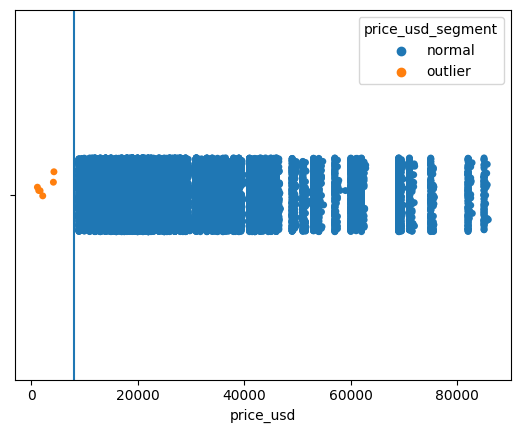

In [36]:
df = prep_data.copy()

ix = df.query('price_usd <= 8000').index
df.loc[:, 'price_usd_segment'] = 'normal'
df.loc[ix, 'price_usd_segment'] = 'outlier'

g = sns.stripplot(data=df, x='price_usd', hue='price_usd_segment')
g.axvline(8000)

prep_data.drop(ix, inplace=True)

# Analysis

## Cluster analysis

* There are 2 clusters for annual_income. The boundary can be where annual_income_log = 11. We can call the clusters as follows:
    * Low income segment
    * Normal and high income segment

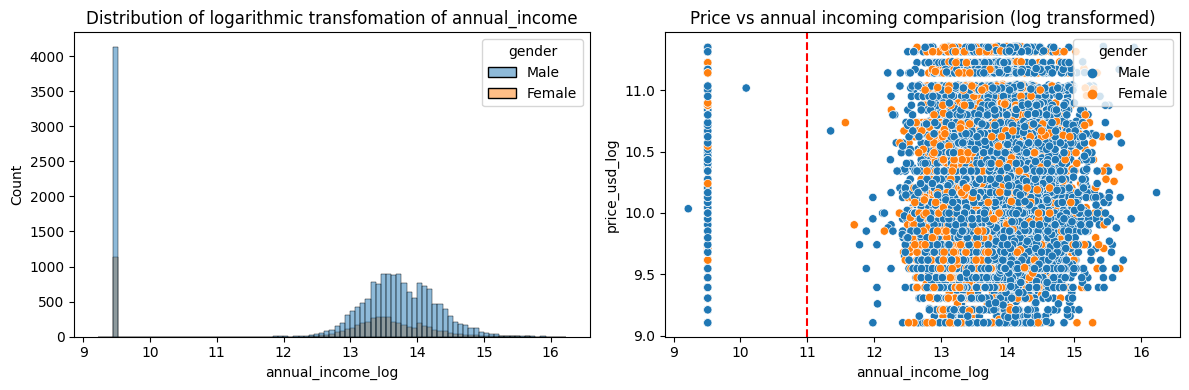

In [40]:
df = prep_data.copy()
df.loc[:, 'annual_income_log'] = np.log(df.loc[:, 'annual_income'] + 1)
df.loc[:, 'price_usd_log'] = np.log(df.loc[:, 'price_usd'] + 1)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.histplot(df, x='annual_income_log', hue='gender', ax=axs[0])
g.set_title('Distribution of logarithmic transfomation of annual_income')

g = sns.scatterplot(
    df,
    x='annual_income_log',
    y='price_usd_log',
    hue='gender',
    ax=axs[1])
g.set_title('Price vs annual incoming comparision (log transformed)')

g.axvline(11, color='red', linestyle='--')

plt.tight_layout()

In [41]:
# set segment feature
ix = df\
    .query('annual_income_log <= 11')\
    .query('price_usd_log >= 9')\
    .index
prep_data.loc[ix, 'customer_segment'] = 'low income'

ix = df\
    .query('annual_income_log > 11')\
    .query('price_usd_log >= 9')\
    .index
prep_data.loc[ix, 'customer_segment'] = 'normal and high income'

ix = df\
    .query('price_usd_log < 9')\
    .index
prep_data.loc[ix, 'customer_segment'] = 'outlier'

prep_data.loc[:, 'customer_segment'].value_counts(dropna=False)

customer_segment
normal and high income    18628
low income                 5272
Name: count, dtype: int64

**Is there segments accross the car prices**
* There are different heads in the distribution of price_usd. This indicates different segments.

<Axes: xlabel='price_usd', ylabel='Density'>

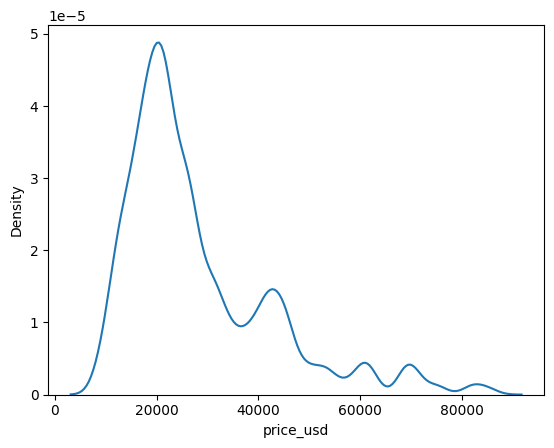

In [42]:
df = prep_data.copy()
sns.kdeplot(df, x='price_usd')

**Are segments of price_usd differ per body_style/gender/city?**
* Price_usd distribution don't differ so much per body_style/gender/city.
* There is no sedan where price_usd > 70k.
* We can name segments as follows:
    * 10k-30k
    * 30k-40k
    * 40k-50k
    * 50k-60k
    * 60k-70k
    * 70k-80k
    * 80k+
    
    For the sake of simplification, price_usd just could be divied to 10k. And the integer part of it could be used as segment name.

In [58]:
prep_data.loc[:, 'price_segment'] = (prep_data.loc[:, 'price_usd'] / 10000).astype(int)

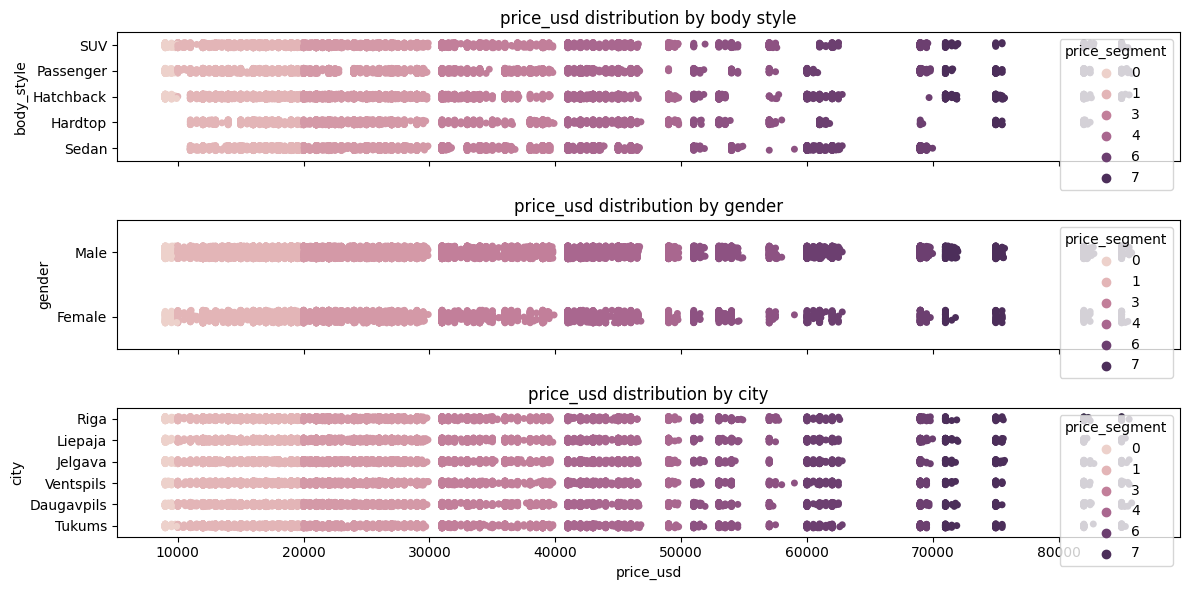

In [59]:
fig, axs = plt.subplots(nrows=3, figsize=(12, 6), sharex=True)

df = prep_data.copy()

g = sns.stripplot(
    data=df,
    x='price_usd',
    y='body_style',
    hue='price_segment',
    ax=axs[0])
g.set_title('price_usd distribution by body style')

g = sns.stripplot(
    data=df,
    x='price_usd',
    y='gender',
    hue='price_segment',
    ax=axs[1])
g.set_title('price_usd distribution by gender')

g = sns.stripplot(
    data=df,
    x='price_usd',
    y='city',
    hue='price_segment',
    ax=axs[2])
g.set_title('price_usd distribution by city')

plt.tight_layout()

## Correlation analysis

* There is positive correlation between amount_paid_for_insurance vs price_usd. Probably, insurance payment is calculated based on price_usd field.
* There is no gender impact.

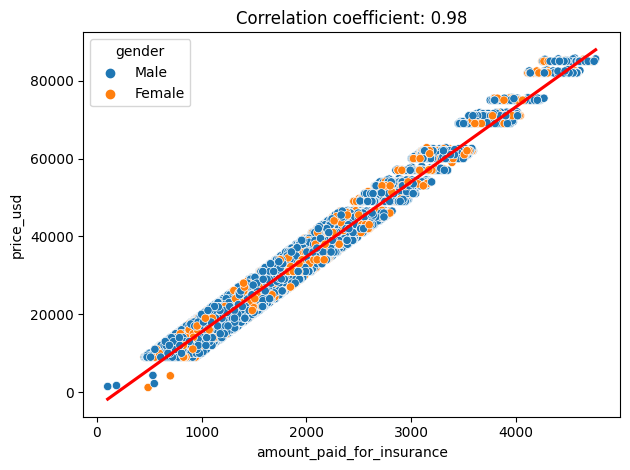

In [9]:
g = sns.regplot(
    prep_data,
    x='amount_paid_for_insurance',
    y='price_usd',
    ci=None,
    line_kws={'color': 'red'},
    scatter=False)

corr_coeff = prep_data\
    .loc[:, ['amount_paid_for_insurance', 'price_usd']]\
    .corr()\
    .iloc[0, 1]\
    .round(2)

g = sns.scatterplot(
    prep_data,
    x='amount_paid_for_insurance',
    y='price_usd',
    hue='gender')

g.set_title(f'Correlation coefficient: {corr_coeff}')

plt.tight_layout()

## Distribution analysis

**do the different customer segments have different cars in terms of price_usd?**
* In Riga, wealthy customers have similar price_usd with non-wealth ones. In all other cities, wealthy customers use higher price_usd cars with non-wealth ones.
* Outliers in Liepeja have very low price_usd cars but they have very high annual_income.

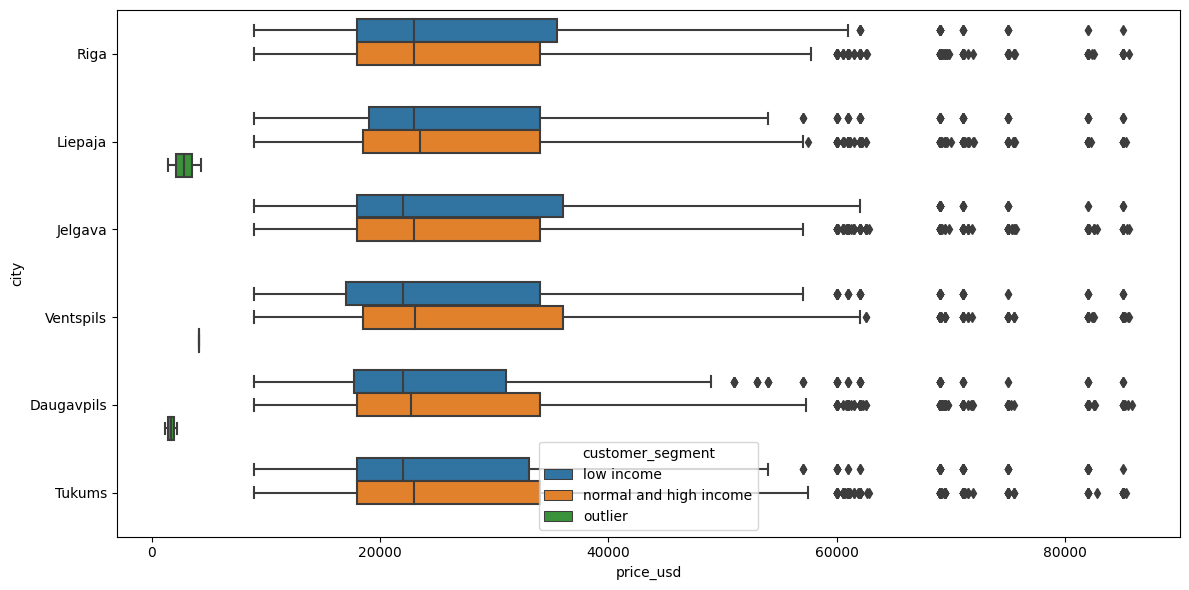

In [15]:
fig, axs = plt.subplots(ncols=1, figsize=(12, 6), sharey=True)

g = sns.boxplot(
    prep_data,
    y='city',
    x='price_usd',
    hue='customer_segment',
    ax=axs)
plt.tight_layout()

## Claim amount analysis

**which type of car brings more cost to the insurance company?**

* women that use passenger have more claims.
* men have higher claim ratio with hatchback and suv cars.

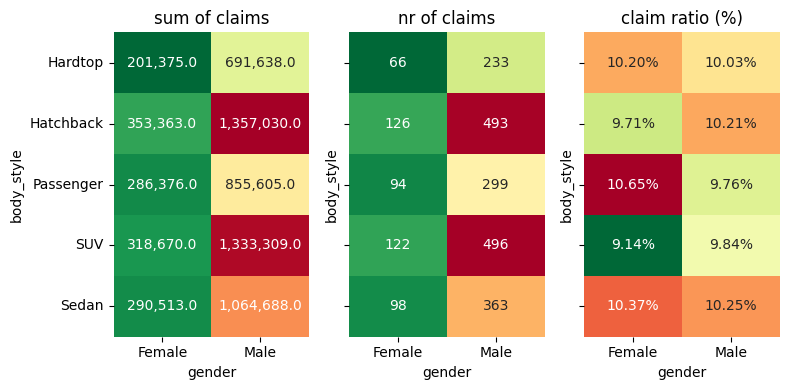

In [19]:
df = prep_data.query('claim_amount > 0').copy()
df_2 = df\
    .groupby(['body_style', 'gender'])\
    .agg(
        sum_of_claims=pd.NamedAgg('claim_amount', 'sum'),
        nr_of_claims=pd.NamedAgg('car_id', 'count'))\
    .reset_index()

df_3 = prep_data.copy()
df_3 = df_3\
    .groupby(['body_style', 'gender'])\
    .agg(
        nr_of_cars=pd.NamedAgg('car_id', 'count'))\
    .reset_index()

df_4 = df_2.merge(
    right=df_3,
    left_on=['body_style', 'gender'],
    right_on=['body_style', 'gender'],
    how='outer')

df_4.loc[:, 'claim_ratio'] = df_4.loc[:, 'nr_of_claims'] / df_4.loc[:, 'nr_of_cars']

fig, axs = plt.subplots(ncols=3, figsize=(8, 4), sharey=True)

df_5 = pd.pivot_table(
    df_4,
    index='body_style',
    columns='gender',
    values='sum_of_claims',
    aggfunc='mean')

sns.heatmap(
    df_5,
    annot=True,
    cmap='RdYlGn_r',
    ax=axs[0],
    cbar=False,
    fmt=',.1f')\
    .set_title('sum of claims')

df_7 = pd.pivot_table(
    df_4,
    index='body_style',
    columns='gender',
    values='nr_of_claims',
    aggfunc='mean')
sns.heatmap(
    df_7,
    annot=True,
    cmap='RdYlGn_r',
    ax=axs[1],
    cbar=False,
    fmt='.0f')\
    .set_title('nr of claims')

df_6 = pd.pivot_table(
    df_4,
    index='body_style',
    columns='gender',
    values='claim_ratio',
    aggfunc='mean')
sns.heatmap(
    df_6,
    annot=True,
    cmap='RdYlGn_r',
    ax=axs[2],
    cbar=False,
    fmt='.2%')\
    .set_title('claim ratio (%)')

plt.tight_layout()

**who makes accident more ? the ones who have better car or the ones who have cheaper car ?**
* the ones who have 10k-45k making more accident than 45k+.
* both male and female are distributed similarly.

Text(0.5, 1.0, 'Distribution of claims w.r.t price_usd')

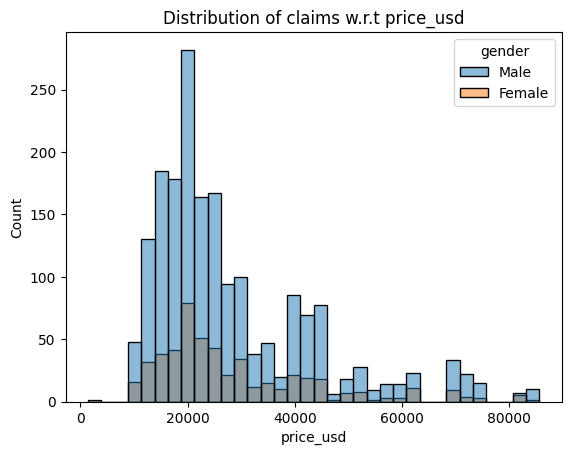

In [20]:
df = prep_data.query('claim_amount > 0').copy()
sns\
    .histplot(
        data=df,
        x='price_usd',
        hue='gender')\
    .set_title('Distribution of claims w.r.t price_usd')

**who has higher claim ratio: expensive cars or cheap cars**
* highest claim ratio are with the cars of 70k.

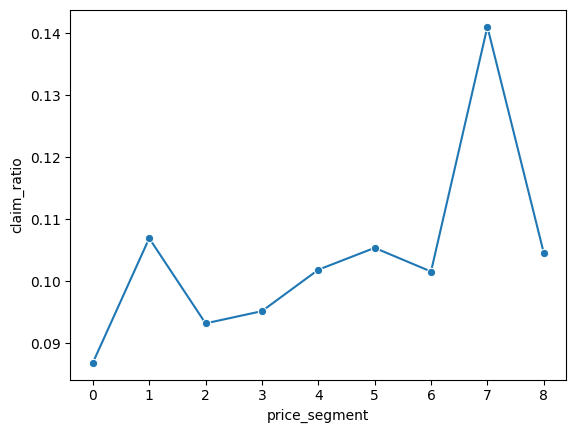

In [67]:
df = prep_data.copy()

df.loc[:, 'is_claim'] = 0
ix = df.query('claim_amount > 0').index
df.loc[ix, 'is_claim'] = 1

df = df\
    .groupby(['price_segment'])\
    .agg(
        nr_of_cars=pd.NamedAgg('car_id', 'count'),
        claim_amounts=pd.NamedAgg('is_claim', 'sum'))\
    .reset_index()

df.loc[:, 'claim_ratio'] = df.loc[:, 'claim_amounts'] / df.loc[:, 'nr_of_cars']

g = sns.lineplot(df, y='claim_ratio', x='price_segment', marker='o')

## Time series analysis

**what is the overall trend of value of claims per month?**
* there is increasing trend with the value of payments.
* looks there is annual seasonality. when the new year starts, claim_amount falls down, until the end of the year there is increasing trend.
* When there 3 months of seasonality decomposition is investigated, a 3 months of seasonality is observed:
    * On the months of 1-4-7-10, it decreases.
    * On the months of 3-6-9-12, it increases.

/tmp/ipykernel_78/1619070.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  g_4.set_xticklabels(g_4.get_xticklabels(), rotation=90)


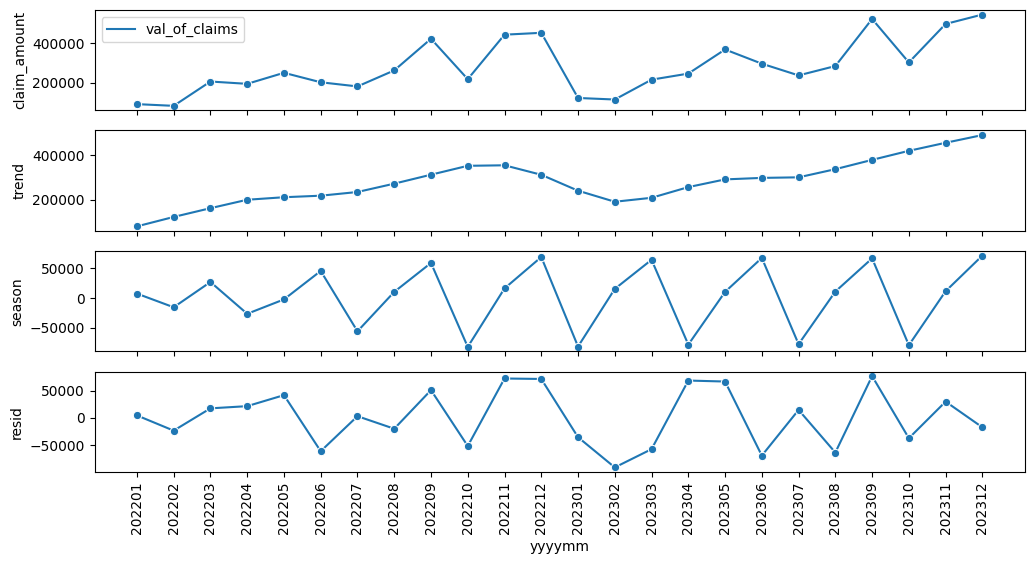

In [68]:
df = prep_data.query('claim_amount > 0').copy()

df = df.groupby('yyyymm').agg(
    val_of_claims=pd.NamedAgg('claim_amount', 'sum'))

srs = df.iloc[:, 0].copy()
stl = STL(srs, period=3)
res_stl = stl.fit()

fig, axs = plt.subplots(nrows=4, figsize=(12, 6), sharex=True)
g_1 = sns.lineplot(df, marker='o', ax=axs[0])

g_1.set_ylabel('claim_amount')

g_2 = sns.lineplot(res_stl.trend, marker='o', ax=axs[1])
g_3 = sns.lineplot(res_stl.seasonal, marker='o', ax=axs[2])
g_4 = sns.lineplot(res_stl.resid, marker='o', ax=axs[3])

g_4.set_xticklabels(g_4.get_xticklabels(), rotation=90)

plt.show()